In [1]:
# Titanic: Machine Learning from Disaster

import sys
import pandas as pd
import numpy as np
import scipy as sp
import IPython
from IPython import display
import sklearn
import random
import time
import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output
print(check_output(["ls","./data"]).decode("utf8"))

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection, model_selection, metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12, 8

print("Version info...")
print("Python: {}". format(sys.version))
print("pandas: {}". format(pd.__version__))
print("matplotlib: {}".format(mpl.__version__))
print("Numpy: {}".format(np.__version__))
print("SciPy: {}".format(sp.__version__))
print("IPython: {}".format(IPython.__version__))
print("scikit-learn: {}".format(sklearn.__version__))

# Step3: Prepare Data for Consumption
### Import data
data_raw = pd.read_csv('./data/train.csv')
data_val = pd.read_csv('./data/test.csv')
data_org = data_raw.copy(deep=True)
data_cleaner = [data_org, data_val]
print(data_raw.info())
data_raw.sample(10)

gender_submission.csv
test.csv
train.csv

Version info...
Python: 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
pandas: 0.25.0
matplotlib: 3.1.0
Numpy: 1.16.4
SciPy: 1.3.1
IPython: 7.7.0
scikit-learn: 0.21.2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
148,149,0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",male,36.5,0,2,230080,26.0000,F2,S
395,396,0,3,"Johansson, Mr. Erik",male,22.0,0,0,350052,7.7958,NaN,S
572,573,1,1,"Flynn, Mr. John Irwin (""Irving"")",male,36.0,0,0,PC 17474,26.3875,E25,S
110,111,0,1,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.0000,C110,S
211,212,1,2,"Cameron, Miss. Clear Annie",female,35.0,0,0,F.C.C. 13528,21.0000,NaN,S
232,233,0,2,"Sjostedt, Mr. Ernst Adolf",male,59.0,0,0,237442,13.5000,NaN,S
525,526,0,3,"Farrell, Mr. James",male,40.5,0,0,367232,7.7500,NaN,Q
650,651,0,3,"Mitkoff, Mr. Mito",male,NaN,0,0,349221,7.8958,NaN,S
636,637,0,3,"Leinonen, Mr. Antti Gustaf",male,32.0,0,0,STON/O 2. 3101292,7.9250,NaN,S
390,391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,S


In [2]:
### Data cleaning: correcting, completing, creating, and converting
print('Train columns with null values:\n{}'.format(data_org.isnull().sum()))
print('-'*10)
print('Test/Validation columns with null values:\n{}'.format(data_val.isnull().sum()))
print('-'*10)
data_raw.describe(include = 'all')

Train columns with null values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Smith, Mr. Richard William",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [3]:
# 1) clean data
for dataset in data_cleaner:
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)
drop_column = ['PassengerId', 'Cabin', 'Ticket']
for col in drop_column:
    data_org.drop(col, axis=1, inplace=True)
#data_org.drop(columns=drop_column, axis=1, inplace=True)
print(data_org.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [7]:
for dataset in data_cleaner:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".",expand=True)[0]
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)           # pd.qcut(): equal-size buckets
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)  # pd.cut(): equal-length

print(data_org['Title'].value_counts())
print("-"*10)
stat_min = 10
title_names = (data_org['Title'].value_counts() < stat_min)    # Boolean
data_org['Title'] = data_org['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data_org['Title'].value_counts())
print("-"*10)
data_org.info()
data_val.info()
data_org.sample(10)

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
Mme               1
Don               1
Capt              1
Sir               1
Jonkheer          1
the Countess      1
Lady              1
Ms                1
Name: Title, dtype: int64
----------
Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Title         891 non-null object
FareBin

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
580,1,2,"Christy, Miss. Julie Rachel",female,25.0,1,1,30.0000,S,3,0,Miss,"(14.454, 31.0]","(16.0, 32.0]"
541,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,31.2750,S,7,0,Miss,"(31.0, 512.329]","(-0.08, 16.0]"
184,1,3,"Kink-Heilmann, Miss. Luise Gretchen",female,4.0,0,2,22.0250,S,3,0,Miss,"(14.454, 31.0]","(-0.08, 16.0]"
754,1,2,"Herman, Mrs. Samuel (Jane Laver)",female,48.0,1,2,65.0000,S,4,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
852,0,3,"Boulos, Miss. Nourelain",female,9.0,1,1,15.2458,C,3,0,Miss,"(14.454, 31.0]","(-0.08, 16.0]"
170,0,1,"Van der hoef, Mr. Wyckoff",male,61.0,0,0,33.5000,S,1,1,Mr,"(31.0, 512.329]","(48.0, 64.0]"
594,0,2,"Chapman, Mr. John Henry",male,37.0,1,0,26.0000,S,2,0,Mr,"(14.454, 31.0]","(32.0, 48.0]"
118,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,247.5208,C,2,0,Mr,"(31.0, 512.329]","(16.0, 32.0]"
225,0,3,"Berglund, Mr. Karl Ivar Sven",male,22.0,0,0,9.3500,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
45,0,3,"Rogers, Mr. William John",male,28.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"


In [14]:
# 2) convert formats
label = LabelEncoder()
for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    
Target = ['Survived']
data_x = ['Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age',
          'Fare', 'FamilySize', 'IsAlone']
data_x_calc = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code',
               'SibSp', 'Parch', 'Age', 'Fare']
data_xy = Target + data_x
print('Original X Y: {}\n'.format(data_xy))

data_x_bin = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 
              'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data_xy_bin = Target + data_x_bin
print('Bin X Y: {}\n'.format(data_xy_bin))

data_dummy = pd.get_dummies(data_org[data_x])
data_x_dummy = data_dummy.columns.tolist()
data_xy_dummy = Target + data_x_dummy
print('Dummy X Y: {}\n'.format(data_xy_dummy))

data_dummy.head()

Original X Y: ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']

Bin X Y: ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']

Dummy X Y: ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs']



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


In [15]:
# 3) Da-Double check cleaned data
print('Train columns with null values:\n{}'.format(data_org.isnull().sum()))
print('-'*10)
print(data_org.info())
print('-'*10)

print('Test/Validation columns with null values:\n{}'.format(data_val.isnull().sum()))
print('-'*10)
print(data_val.info())
print('-'*10)

data_raw.describe(include ='all')

Train columns with null values:
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int64
Title            891 non-null object
FareBin          891 non-null category

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Smith, Mr. Richard William",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [17]:
# 4) Split training and testing data
train_x, test_x, train_y, test_y = model_selection.train_test_split(data_org[data_x_calc], data_org[Target], random_state=0)
train_x_bin, test_x_bin, train_y_bin, test_y_bin = model_selection.train_test_split(data_org[data_x_bin], data_org[Target], random_state=0)
train_x_dummy, test_x_dummy, train_y_dummy, test_y_dummy = model_selection.train_test_split(data_dummy[data_x_dummy], data_org[Target], random_state=0)

print("Data_org shape: {}".format(data_org.shape))
print("Train data shape: {}".format(train_x.shape))
print("Test data shape: {}".format(test_x.shape))
train_x_bin.head()

Data_org shape: (891, 19)
Train data shape: (668, 8)
Test data shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


In [18]:
# Step4: Perform Exploratory Analysis with Statistics
### discrete variable correlation by 'Survival'
for x in data_x:
    if data_org[x].dtype != 'float64':
        print('Survival Correlation by:', x)
        print(data_org[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10,'\n')
        
print(pd.crosstab(data_org['Title'], data_org[Target[0]]))


Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1 

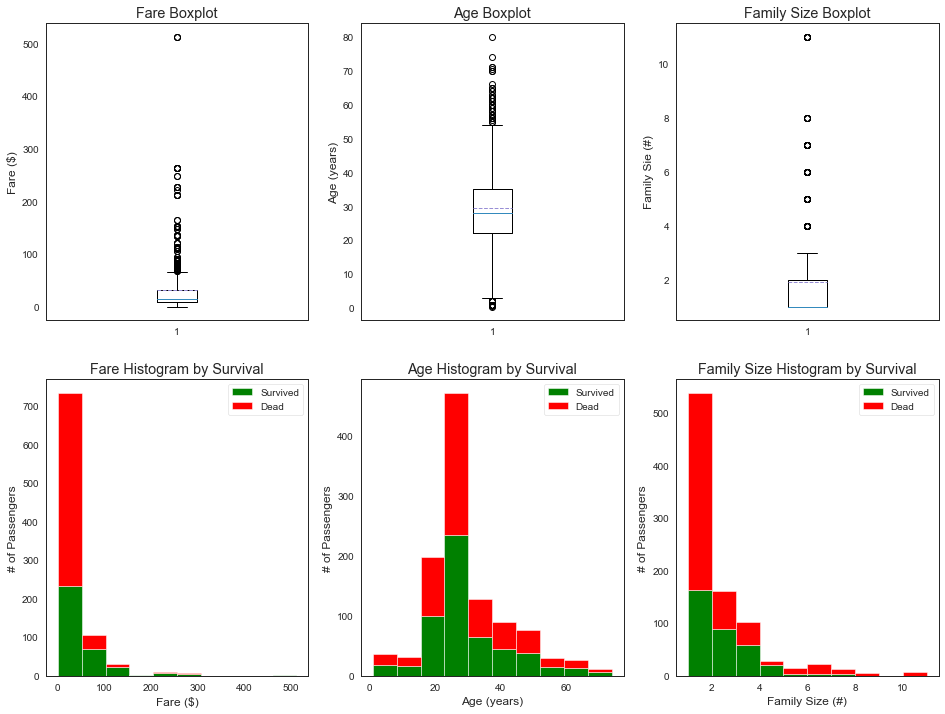

In [22]:
### Visualization
plt.figure(figsize=[16,12])

# distribution of quantitative data
plt.subplot(231)
plt.boxplot(x=data_org['Fare'], showmeans=True, meanline=True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(x=data_org['Age'], showmeans=True, meanline=True)
plt.title('Age Boxplot')
plt.ylabel('Age (years)')

plt.subplot(233)
plt.boxplot(x=data_org['FamilySize'], showmeans=True, meanline=True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Sie (#)')

plt.subplot(234)
plt.hist(x=[data_org[data_org['Survived']==1]['Fare'], data_org[data_org['Survived']==0]['Fare']],
         stacked=True, color=['g','r'], label=['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x=[data_org[data_org['Survived']==0]['Age'], data_org[data_org['Survived']==0]['Age']],
         stacked=True, color=['g','r'], label=['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x=[data_org[data_org['Survived']==1]['FamilySize'], data_org[data_org['Survived']==0]['FamilySize']],
         stacked=True, color=['g','r'], label=['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()


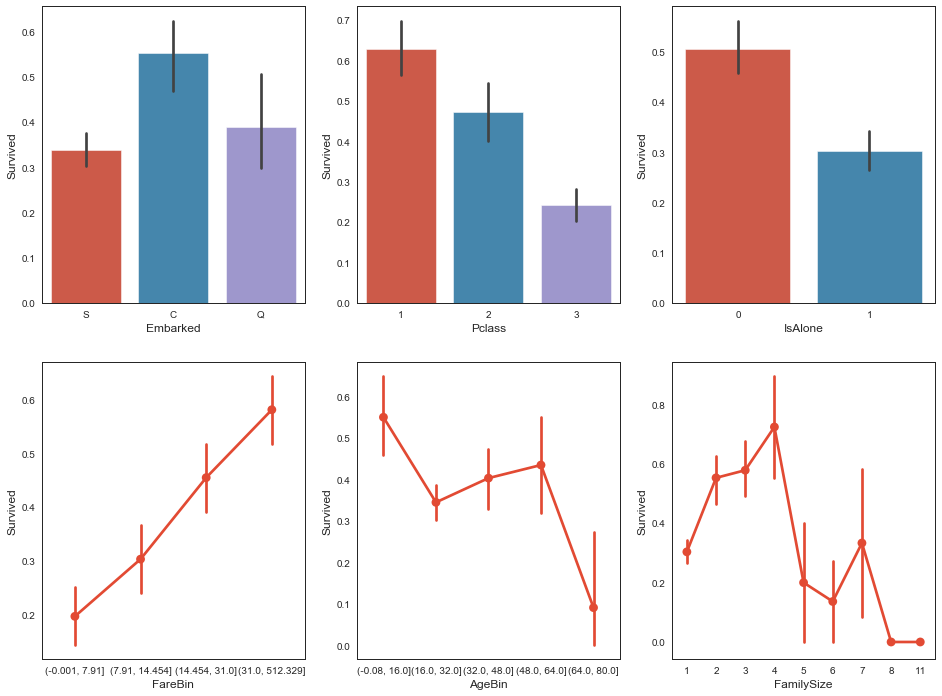

In [25]:
# multi-variable comparison
fig, saxis = plt.subplots(2, 3, figsize=(16,12))
sns.barplot(x='Embarked', y='Survived', data=data_org, ax=saxis[0,0])
sns.barplot(x='Pclass', y='Survived', data=data_org, ax=saxis[0,1])
sns.barplot(x='IsAlone', y='Survived', data=data_org, ax=saxis[0,2])
sns.pointplot(x='FareBin', y='Survived', data=data_org, ax=saxis[1,0])
sns.pointplot(x='AgeBin', y='Survived', data=data_org, ax=saxis[1,1])
sns.pointplot(x='FamilySize', y='Survived', data=data_org, ax=saxis[1,2])


Text(0.5, 1.0, 'Pclass vs Family Size Survival Comparison')

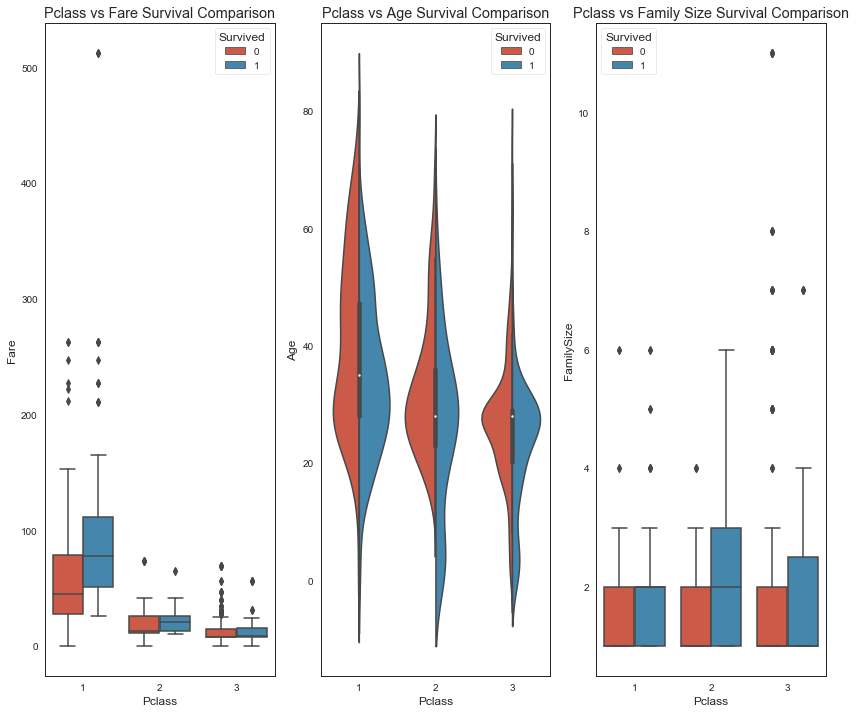

In [28]:
# compare Pclass and a 2nd feature(numeric value)
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(14,12))
sns.boxplot(x='Pclass', y='Fare', hue='Survived', data=data_org, ax=axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')
sns.violinplot(x='Pclass', y='Age', hue='Survived', data=data_org, split=True, ax=axis2)
axis2.set_title('Pclass vs Age Survival Comparison')
sns.boxplot(x='Pclass', y='FamilySize', hue='Survived', data=data_org, ax=axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')


Text(0.5, 1.0, 'Sex vs IsAlone Survival Comparison')

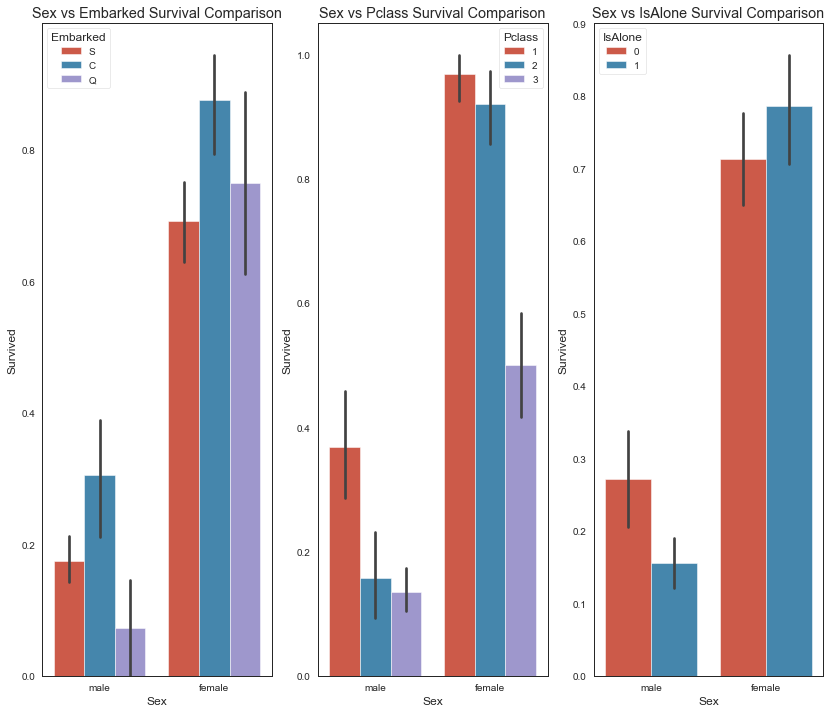

In [30]:
# compare Sex and a 2nd feature(nominal value)
fig, qaxis = plt.subplots(1,3,figsize=(14,12))
# Error: sns.barplot(x='Sex', y='Embarked', hue='Survived', data=data_org, ax=qaxis[1])
sns.barplot(x='Sex', y='Survived', hue='Embarked', data=data_org, ax=qaxis[0])
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=data_org, ax=qaxis[1])
sns.barplot(x='Sex', y='Survived', hue='IsAlone', data=data_org, ax=qaxis[2])
qaxis[0].set_title('Sex vs Embarked Survival Comparison')
qaxis[1].set_title('Sex vs Pclass Survival Comparison')
qaxis[2].set_title('Sex vs IsAlone Survival Comparison')


Text(0.5, 1.0, 'Class vs Sex in Survival')

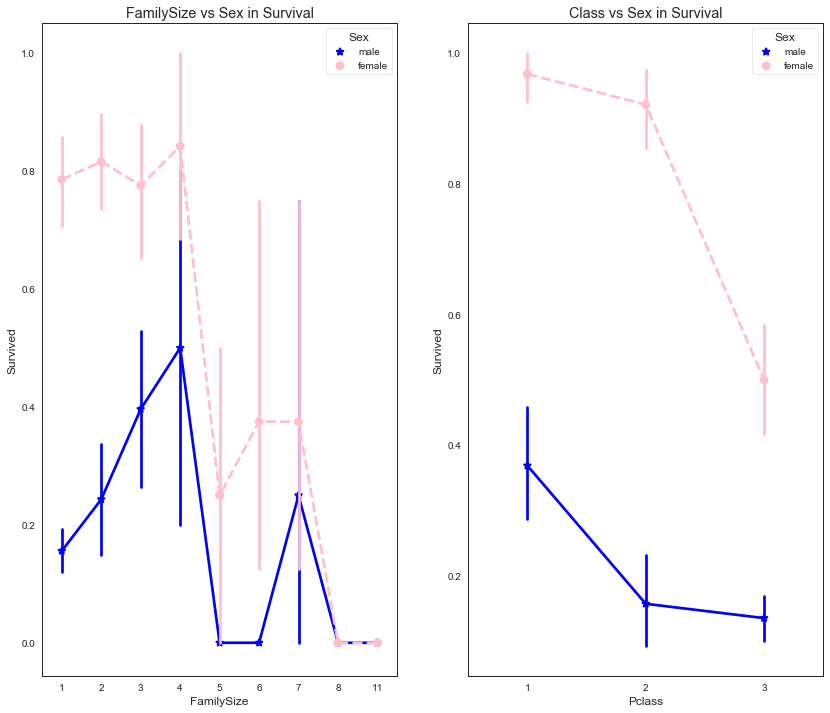

In [33]:
# more side-by-side comparison
fig, (maxis1, maxis2) = plt.subplots(1,2,figsize=(14,12))
## how does family size factor with sex & survival
sns.pointplot(x='FamilySize',y='Survived',hue='Sex',data=data_org,
              palette={"male": "blue", "female": "pink"}, 
              markers=["*","o"], linestyles=["-","--"], ax=maxis1)
maxis1.set_title('FamilySize vs Sex in Survival')
## how does class factor with sex & survival
sns.pointplot(x='Pclass',y='Survived',hue='Sex',data=data_org,
              palette={"male": "blue", "female": "pink"}, 
              markers=["*","o"], linestyles=["-","--"], ax=maxis2)
maxis2.set_title('Class vs Sex in Survival')

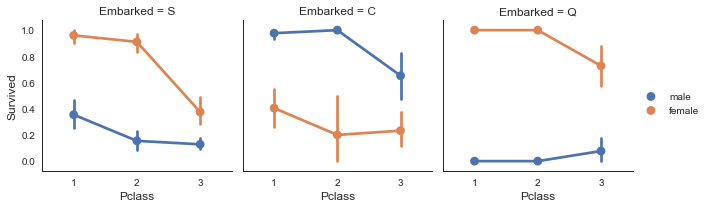

In [34]:
## how does embark port factor with class, sex, and survival
e = sns.FacetGrid(data_org, col='Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette='deep')
e.add_legend()

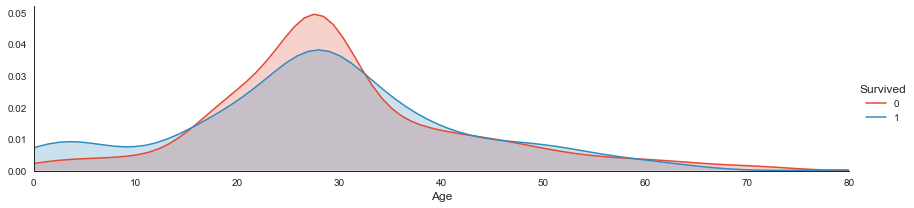

In [41]:
## distributions of age of passengers who survived or didn't
a = sns.FacetGrid(data_org, hue='Survived', aspect=4)
a.map(sns.kdeplot, 'Age', shade=True)
a.set(xlim=(0, data_org['Age'].max()))
a.add_legend()

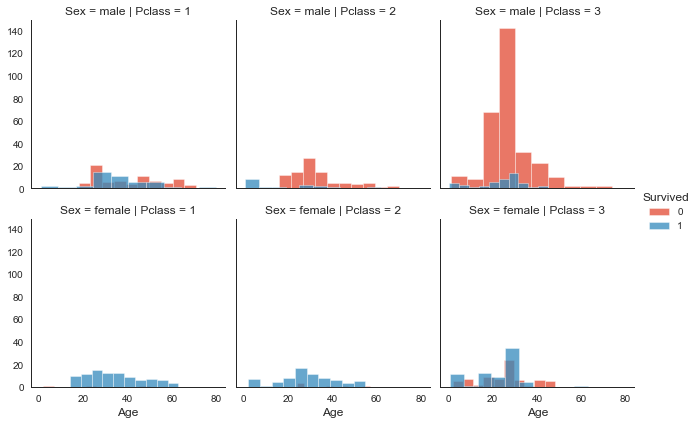

In [42]:
## histogram of sex, class, and age by survival
h=sns.FacetGrid(data_org, row='Sex', col='Pclass', hue='Survived')
h.map(plt.hist, 'Age', alpha=.75)
h.add_legend()

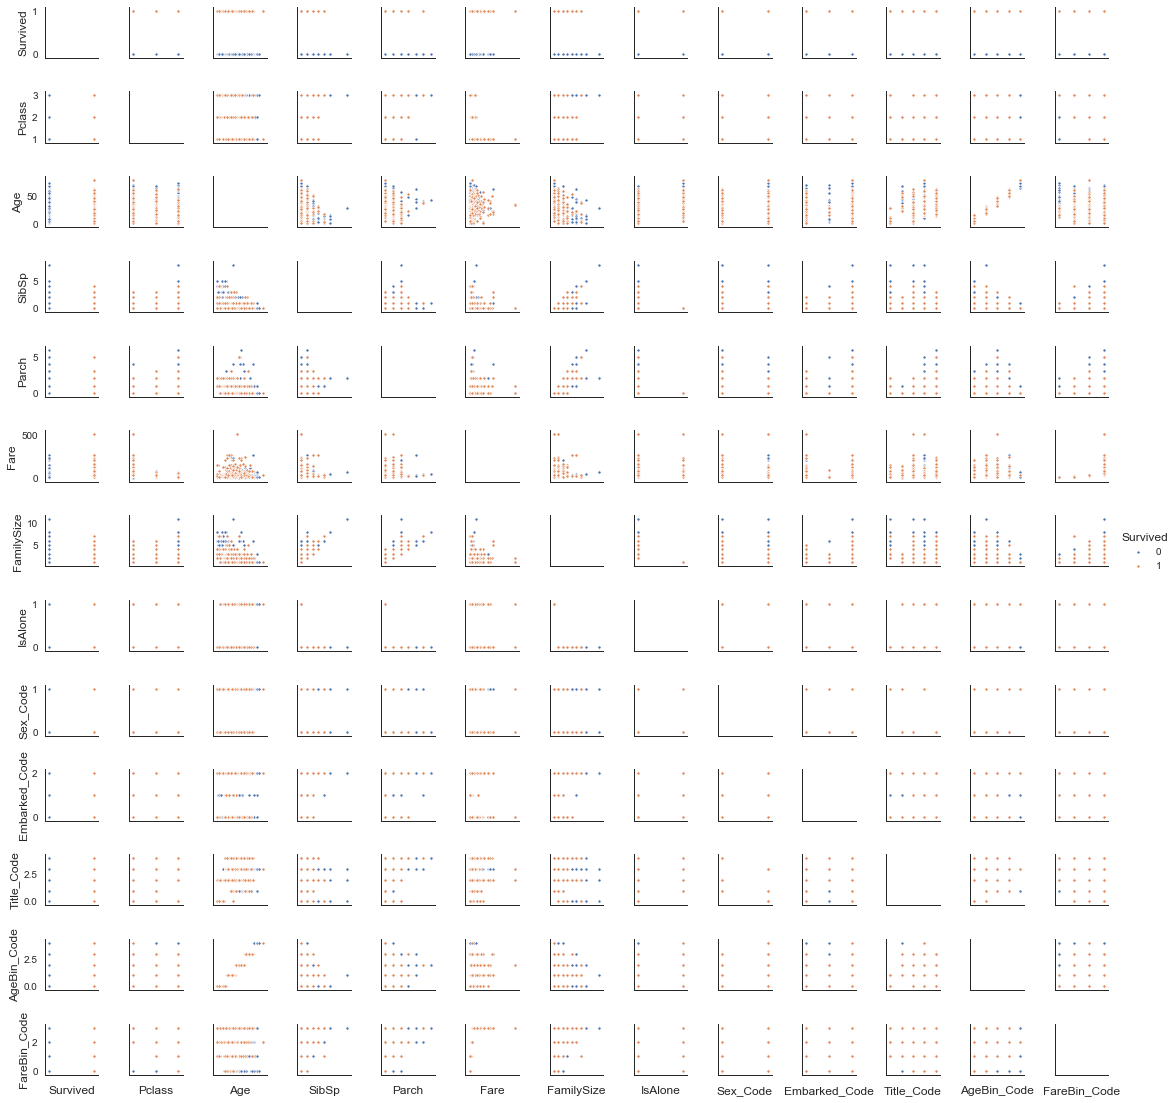

In [49]:
## pair plots of entire dataset
pp = sns.pairplot(data_org, hue='Survived',palette='deep', size=1.2,
                  diag_kind='histogram', diag_kws=dict(shade=True), plot_kws=dict(s=10))
#pp = sns.pairplot(data_org, hue='Survived', palette='deep', size=1.2,
#                  diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
### error: Singular matrix error
pp.set(xticklabels=[])

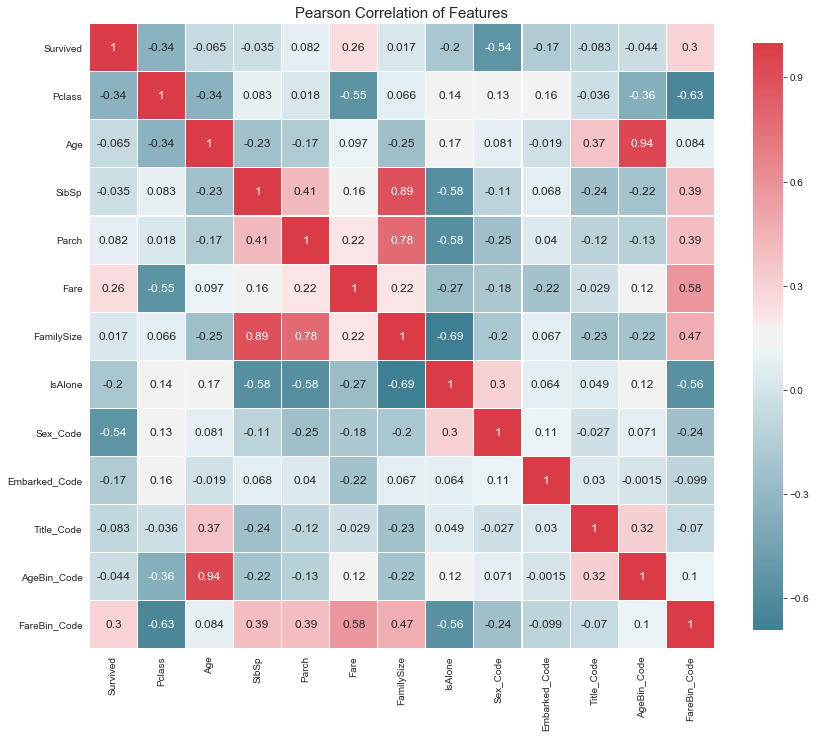

In [51]:
## correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize=(14,12))
    colormap = sns.diverging_palette(220,10,as_cmap=True)
    _ = sns.heatmap(
        df.corr(),
        cmap = colormap, 
        square = True, 
        cbar_kws = {'shrink':.9},
        ax = ax, 
        annot = True, 
        linewidths=0.1, vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12})
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
correlation_heatmap(data_org)

In [63]:
# Step5: Model Data
# Machine Learning Algorithm(MLA) selection
MLA = [
    # Ensemble methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    # Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    # GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(), 
    # Naive Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    # SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    # Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    # XGBoost
    XGBClassifier()
]

# split dataset
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=.3, train_size=.6, random_state=0)
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 
               'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns=MLA_columns)
MLA_predict = data_org[Target]

# run through MLAs
row_index = 0
for alg in MLA:
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    cv_results = model_selection.cross_validate(alg, data_org[data_x_bin], data_org[Target], 
                                                cv=cv_split, return_train_score=True)
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3.0
    
    alg.fit(data_org[data_x_bin], data_org[Target])
    MLA_predict[MLA_name] = alg.predict(data_org[data_x_bin])
    row_index+=1
    
MLA_compare.sort_values(by=['MLA Test Accuracy Mean'], ascending=False, inplace=True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.856367,0.829478,0.0527546,0.0413161
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.837266,0.826119,0.0453876,0.0322273
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.890824,0.822761,0.0699515,0.0143726
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.835768,0.822761,0.0493681,0.0358001
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.895131,0.822015,0.0602921,0.0121907
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.866667,0.822015,0.0529916,0.0711644
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.820522,0.0553963,0.00289693
18,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.820149,0.0479648,0.00278561
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.892135,0.815299,0.0710182,0.0133914
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.850375,0.813806,0.0690863,0.00292981


Text(0, 0.5, 'Algorithm')

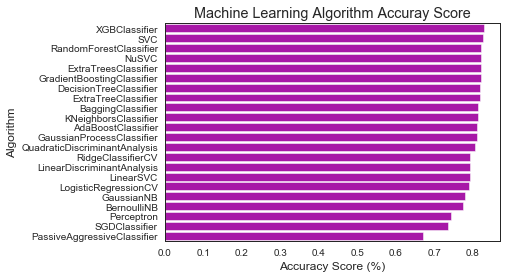

In [64]:
# visualize comparison of MLA performances
sns.barplot(x='MLA Test Accuracy Mean', y='MLA Name', data=MLA_compare, color='m')
plt.title('Machine Learning Algorithm Accuray Score')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [66]:
### Evaluate Model Performance
# hanmade model
for index, row in data_org.iterrows():
    if random.random() > 0.5:
        data_org.set_value(index, 'Random_Predict', 1) #predict survived
    else:
        data_org.set_value(index, 'Random_Predict', 0) #predict died
        
data_org['Random_Score'] = 0 #assume prediction wrong
data_org.loc[(data_org['Survived'] == data_org['Random_Predict']), 'Random_Score'] = 1
print('Coin Flip Model Accuracy: {:.2f}%'.format(data_org['Random_Score'].mean()*100))
print('Coin Flip Model Accuracy w/SciKit: {:.2f}%'.format(metrics.accuracy_score(data_org['Survived'],data_org['Random_Predict'])*100))


Coin Flip Model Accuracy: 50.17%
Coin Flip Model Accuracy w/SciKit: 50.17%


In [68]:
# group by pivot table
pivot_female = data_org[data_org.Sex=='female'].groupby(['Sex','Pclass','Embarked','FareBin'])['Survived'].mean()
print('Survival Decision Tree w/Female Node: \n{}'.format(pivot_female))
pivot_male = data_org[data_org.Sex=='male'].groupby(['Sex','Title'])['Survived'].mean()
print('Survival Decision Tree w/Male Node: \n{}'.format(pivot_male))

Survival Decision Tree w/Female Node: 
Sex     Pclass  Embarked  FareBin        
female  1       C         (-0.001, 7.91]          NaN
                          (7.91, 14.454]          NaN
                          (14.454, 31.0]     0.666667
                          (31.0, 512.329]    1.000000
                Q         (-0.001, 7.91]          NaN
                          (7.91, 14.454]          NaN
                          (14.454, 31.0]          NaN
                          (31.0, 512.329]    1.000000
                S         (-0.001, 7.91]          NaN
                          (7.91, 14.454]          NaN
                          (14.454, 31.0]     1.000000
                          (31.0, 512.329]    0.955556
        2       C         (-0.001, 7.91]          NaN
                          (7.91, 14.454]     1.000000
                          (14.454, 31.0]     1.000000
                          (31.0, 512.329]    1.000000
                Q         (-0.001, 7.91]          NaN
 

In [69]:
# handmade data model
def mytree(df):
    Model = pd.DataFrame(data={'Predict':[]})
    male_title = ['Master']
    for index, row in df.iterrows():
        #Q1: Were you on the Titanic? majority died
        Model.loc[index, 'Predict'] = 0
        #Q2: Are you female? majority survived
        if (df.loc[index, 'Sex']=='female'):
            Model.loc[index,'Predict'] = 1
        #Q3A Female-Class and Q4 Embarked gain minimum information
        #Q5B Female-FareBin set anythin less than 0.5
        if ((df.loc[index, 'Sex']=='female') & 
            (df.loc[index, 'Pclass']==3) &
            (df.loc[index, 'Embarked']=='S') &
            (df.loc[index, 'Fare'] > 8)):
            Model.loc[index, 'Predict'] = 0
        #Q3B Male-Title set anything greater than 0.5 for majority survived
        if ((df.loc[index, 'Sex']=='male') &
            (df.loc[index, 'Title'] in male_title)):
            Model.loc[index, 'Predict'] = 1
    return Model

Tree_Predict = mytree(data_org)
print('Decision Tree Model Accuracy Score: {:.2f}%'.format(metrics.accuracy_score(data_org['Survived'],Tree_Predict)*100))

# accuracy summary report
## recall score = (true positives)/(true pos.+false neg.)
## F1 score = weighted average of precision and recall
print(metrics.classification_report(data_org['Survived'], Tree_Predict))

            

Decision Tree Model Accuracy Score: 82.04%
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       549
           1       0.82      0.68      0.75       342

    accuracy                           0.82       891
   macro avg       0.82      0.79      0.80       891
weighted avg       0.82      0.82      0.82       891



Confusion matrix w/o normalization
[[497  52]
 [108 234]]
Normalized confusion matrix
[[0.91 0.09]
 [0.32 0.68]]


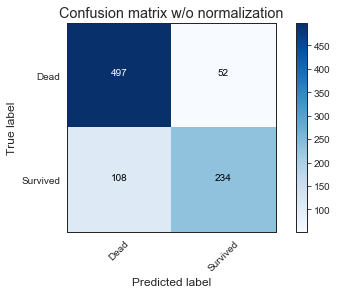

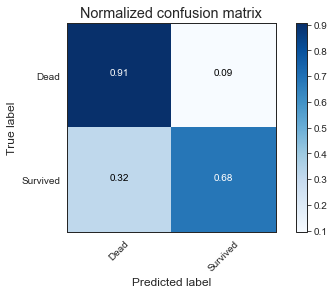

In [77]:
# plot accuracy summary
import itertools
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized confusion matrix"
        #print("Normalized confusion matrix")
    else:
        title = "Confusion matrix w/o normalization"
        #print("Confusion matrix w/o normalization")
    print(title)
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() /2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = metrics.confusion_matrix(data_org['Survived'], Tree_Predict)
np.set_printoptions(precision=2)
class_names = ['Dead', 'Survived']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
